Copyright (C) 2016 Glencoe Software, Inc.
All Rights Reserved.

This program is free software; you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation; either version 2 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License along
with this program; if not, write to the Free Software Foundation, Inc.,
51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.

# Working with the analytical data stored on the OMERO server


* Download an OMERO File annotation to a CSV file
* Read in data
* Perform statistical analysis ([pandas](http://pandas.pydata.org/))
* Run Principal Component Analysis (PCA) ([scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html))

This notebook demonstarates how to retrieve analytical data stored as a [file annotation](http://www.openmicroscopy.org/site/support/omero5.2/developers/Model/StructuredAnnotations.html) from the [OMERO.server](http://www.openmicroscopy.org/site/products/omero), perform basic statistical analysis using [pandas](http://pandas.pydata.org/) and explore the feature space with Principle Component Analysis using [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

The video tutorial for this notebook can be found on [Glencoe Software, Inc.](http://glencoesoftware.com/webinars.html) website (look for: OMERO Plus for High Content Screening & Analysis: The Gold Standard in Data Management & Integration).

### Connect to the OMERO server

In [5]:
import os
import omero
from omero.gateway import BlitzGateway
import gs_analytics

from getpass import getpass
from getpass import getpass
conn = BlitzGateway(
    raw_input("Username: "), getpass("OMERO Password: "),
    host=raw_input("Host: "), port=int(raw_input("Port: ")))
conn.connect()

Username: your_username
OMERO Password: ········
Host: your.server.address
Port: 4064


False

### Import matplotlib

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (12.0, 7.0)

from IPython.display import display, HTML

### Download a CSV file and read in data for selected columns

In [3]:
# Create temp directory to download the date to
from omero.util.temp_files import manager
directory = manager.gettempdir().encode("UTF-8")
# Request the file annotation
annotation_id = raw_input("Annotation id: ")
file_annotation = conn.getObject('FileAnnotation', annotation_id)
file_name = file_annotation.getFileName()
# Download the file annotation to the disk
file_path = os.path.join(directory, file_name)
f = open(file_path, 'w')
try:
    for chunk in file_annotation.getFileInChunks():
        f.write(chunk)
finally:
    f.close()
display("File downloaded to: %s" % file_path)
f = open(file_path, 'r')
try:
    header = f.readline().strip().split(',')
finally:
    f.close()
display("Number of columns: %s" % len(header))

Annotation id: 7391


'File downloaded to: /Users/emilrozbicki/omero/tmp/omero_emilrozbicki/10916/CP_Nuclei.csv'

'Number of columns: 109'

In [4]:
column_names = [
    'ImageNumber', 'ObjectNumber', 'AreaShape_Area', 'AreaShape_Compactness',
    'AreaShape_Eccentricity', 'AreaShape_Perimeter', 'AreaShape_Solidity', 'AreaShape_Orientation',
    'AreaShape_MeanRadius', 'AreaShape_FormFactor', 'AreaShape_Extent', 'Neighbors_NumberOfNeighbors_1',
    'Intensity_MeanIntensityEdge_Hoechst', 'Intensity_MeanIntensity_Ph_Golgi']
data = gs_analytics.read_and_filter(file_path, column_names)
display("Number of rows: %i" % (len(data) - 1))

'Number of rows: 82167'

### Convert the data to pandas DataFrame object

In [5]:
import pandas as pd
df = pd.DataFrame(data[1:], columns=data[0])
convert_list = list(column_names)
to_clear = ["ImageNumber", "ObjectNumber"]
[convert_list.remove(x) for x in to_clear]
df[convert_list] = df[convert_list].astype(float)
data = gs_analytics.read_and_filter(file_path, convert_list)

### Calculate statistics

In [6]:
df.describe()

,AreaShape_Area,AreaShape_Compactness,AreaShape_Eccentricity,AreaShape_Perimeter,AreaShape_Solidity,AreaShape_Orientation,AreaShape_MeanRadius,AreaShape_FormFactor,AreaShape_Extent,Neighbors_NumberOfNeighbors_1,Intensity_MeanIntensityEdge_Hoechst,Intensity_MeanIntensity_Ph_Golgi
count,82167.000000,82167.000000,82167.000000,82167.000000,82167.000000,82167.000000,82167.000000,82167.000000,82167.000000,82167.000000,82167.000000,82167.000000
mean,2530.724135,1.149703,0.736120,197.172422,0.958718,-1.448501,8.439737,0.783482,0.702538,0.309674,0.056282,0.401329
std,1249.631128,0.489106,0.125371,52.914846,0.031324,53.450115,1.944945,0.081891,0.070925,0.525328,0.021924,0.169783
min,315.000000,1.000198,0.078355,65.350000,0.277643,-89.999505,1.290069,0.028206,0.017977,0.000000,0.015199,0.013581
25%,1832.000000,1.068910,0.678749,170.738000,0.955462,-49.216350,7.365227,0.751334,0.658838,0.000000,0.047772,0.282870
50%,2356.000000,1.114606,0.764062,192.980000,0.967810,-2.880187,8.395238,0.798505,0.711654,0.000000,0.052420,0.359791
75%,2957.000000,1.179926,0.823125,217.846000,0.972880,46.403110,9.412115,0.834636,0.755102,1.000000,0.059720,0.476709
max,17597.000000,57.248129,0.999958,2206.184000,1.042274,89.999917,23.442325,0.951967,0.884170,9.000000,0.999999,0.999873


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1130ca790>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1124f34d0>]], dtype=object)

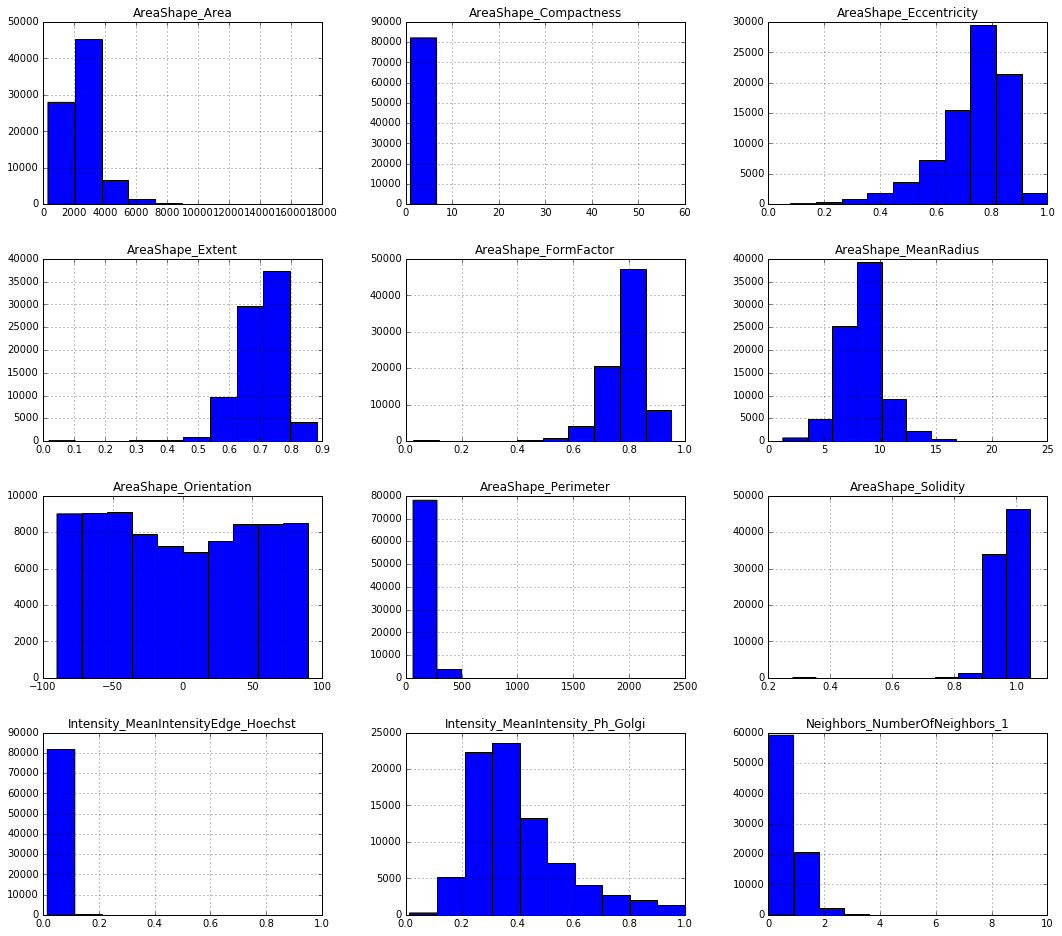

In [7]:
matplotlib.rcParams['figure.figsize'] = (18.0, 16.0)
df.hist()

### Principal Component Analysis using scikit-learn

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = data[1:]
X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components=10)
X_r = pca.fit(X_std).transform(X_std)

### Visualise PCA result

#### Feature table list

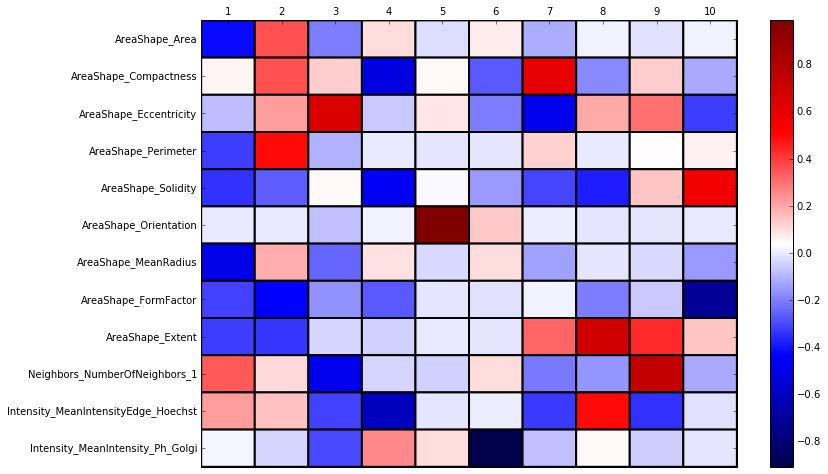

In [9]:
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
import matplotlib.cm as cm
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
im = ax.pcolor(pca.components_.transpose(), cmap=cm.seismic, edgecolors='k', linewidths=2)
gs_analytics.set_axis_properties_pca(ax, range(1, 11), convert_list[0:12])
plt.colorbar(im)

#### Explained variance ratio

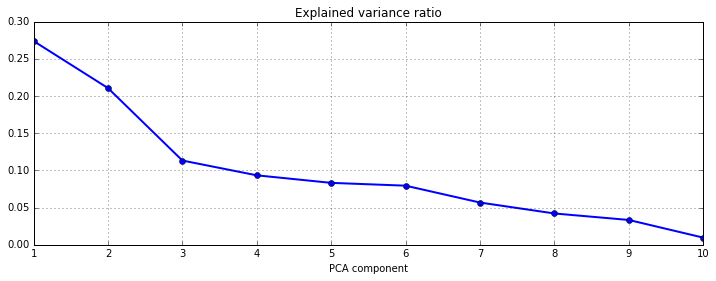

In [10]:
matplotlib.rcParams['figure.figsize'] = (12.0, 4.0)
import matplotlib.cm as cm
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
plt.plot(pca.explained_variance_ratio_, marker='o', linewidth=2)
ax.xaxis.set(ticklabels=range(1, 11))
plt.xlabel('PCA component')
plt.grid(True)
plt.title('Explained variance ratio')

#### PCA Component 1 vs Component 2

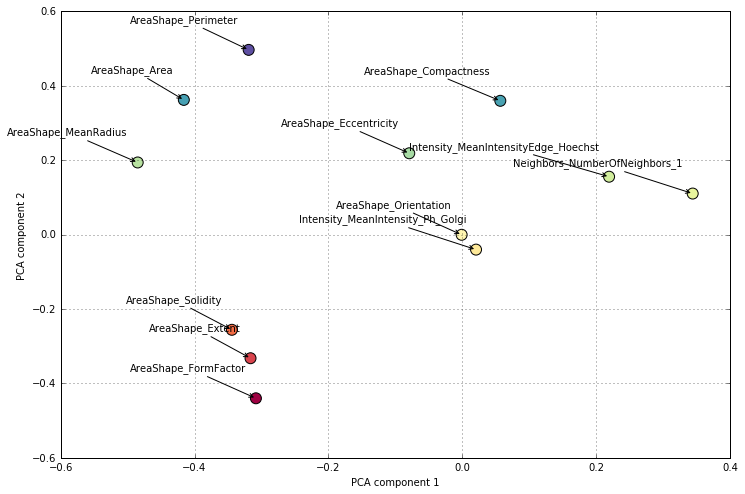

In [11]:
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
import matplotlib.cm as cm
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
plt.scatter(
    pca.components_[0], pca.components_[1],
    marker='o', c=pca.components_[1], s=120, cmap=plt.get_cmap('Spectral'))
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
gs_analytics.add_labels(plt, convert_list, pca.components_[0], pca.components_[1])
plt.grid(True)

### Disconnect from the OMERO server

In [12]:
conn._closeSession()